# Get 1D mass from fit to sbp extrapolated 

I am fitting between 50 and 100kpc and then extrapolating to 500kpc, integrating from 100 to 500 to get the mass and then adding that to the mass at 100kpc given by galSBP. I did 2 fits: a power law fit to mu and r in linear space, and a linear fit in log-log space. I realize it’s essentially the same thing, with an additional parameter in the power law fit, but I thought it would be good to compare. The power law fit better recovers the total mass from the galSBP measurement, so I will use that one. I just wanted to make sure that I am doing it correctly.

In [1]:
import numpy as np
import sep
import h5py
import fitsio
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import glob

from scipy.optimize import curve_fit
from scipy.integrate import quad

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [2]:
#interpolated 1D mass
def oneD_mass(galaxy_iso, radius):
    mass=np.interp(radius,galaxy_iso['sma_kpc'], galaxy_iso['growth_ori'])
    return np.log10(mass)

In [3]:
#open pickels
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_quick.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_isos_quick.pkl'

tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_quick.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_quick.pkl'

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

illustris_masses = open_pkl(illustris_masses_file)
tng_masses = open_pkl(tng_masses_file)
illustris_isos = open_pkl(illustris_isos_file)
tng_isos = open_pkl(tng_isos_file)

In [4]:
iso=illustris_isos[0]

Text(0.5,0,u'$\\mathrm{SMA/kpc}$')

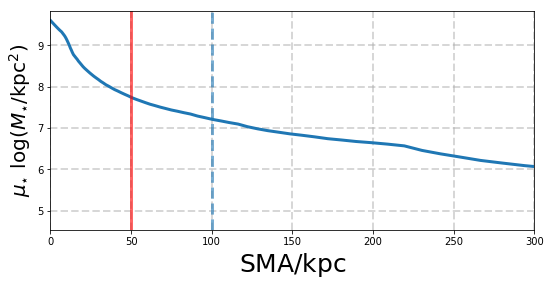

In [5]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

ax1.plot((iso['sma_kpc']), 
         np.log10(iso['intens_kpc']), linewidth=3.0)

ax1.set_ylabel(r'$\mu_{\star}\ \log(M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(50, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(0, 300)
ax1.set_xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)


# fit power law between 50 and 100 kpc 

In [17]:


# def powerlaw(x, m, c, c0):
#     return c0 + x**m * c
def powerlaw(x, m, c):
    return x**m * c

x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]

In [7]:
p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10])
p_fit_power

array([ -1.71233713e+00,   4.47177777e+10])

Text(0.5,0,u'$\\mathrm{SMA/kpc}$')

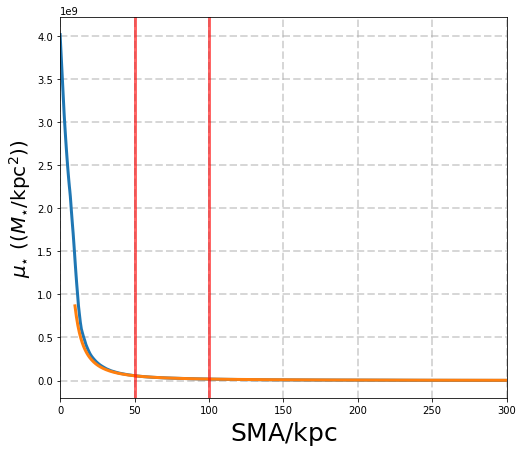

In [8]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.plot((iso['sma_kpc']), iso['intens_kpc'], linewidth=3.0)

x=np.linspace(10,300,600)
plt.plot(x, powerlaw(x,*p_fit_power), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}\ ((M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(100.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline(50, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.xlim(0, 300)
plt.xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)

Text(0.5,0,u'$\\mathrm{SMA/kpc}$')

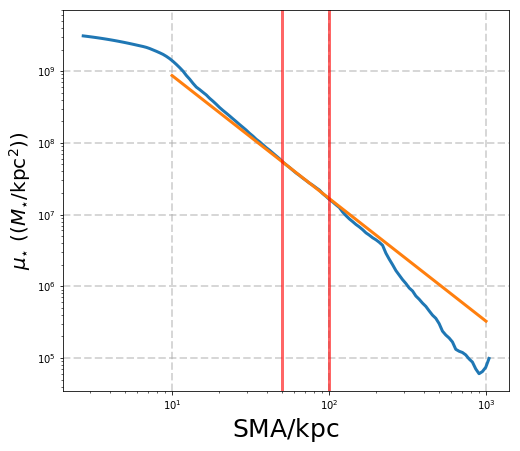

In [9]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.loglog((iso['sma_kpc']), iso['intens_kpc'], linewidth=3.0)

x=np.linspace(10,1000,600)
plt.loglog(x, powerlaw(x,*p_fit_power), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}\ ((M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(100.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline(50, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#plt.xlim(0, 300)
plt.xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)

In [18]:
#integrate over area
def power_law_r(x, m, c, c0):
    return powerlaw(x, m, c, c0)*x

In [27]:
tuple(p_fit_power) +(0,)

(-1.7123371342646292, 44717777732.362869, 0)

In [28]:
mass_int, mass_err =quad(power_law_r, 100, 500, args=tuple(p_fit_power)+(0,))
mass_int

TypeError: powerlaw() takes exactly 3 arguments (4 given)

In [12]:
mass_100 = 10**(oneD_mass(iso, 100))
mass_beyond100 = mass_int
power_law_fit_mass = np.log10(mass_100+mass_beyond100)
power_law_fit_mass

NameError: name 'mass_int' is not defined

In [160]:
iso['mag_tot'][0]/-2.5

12.241892114354755

# fit line in log-log

In [13]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

def line(x, m, b):
    return b + x*m 


x=np.log10(iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)])
y=np.log10(iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)])
p_fit_line, _ = curve_fit(line, x, y)
p_fit_line

array([ -1.7027239,  10.6330596])

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


NameError: name 'p_fit' is not defined

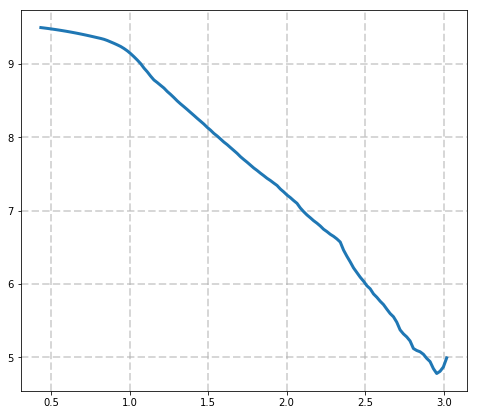

In [14]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.plot(np.log10(iso['sma_kpc']), 
         np.log10(iso['intens_kpc']), linewidth=3.0)

x=np.linspace(0.5,3)
plt.plot(x, line(x,*p_fit), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}\ (\log(M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(np.log10(100.0), linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline(np.log10(50), linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#plt.xlim(0, 300)
plt.xlabel(r'$\mathrm{\log{(SMA/kpc)}}$', fontsize=25)

### convert from log to linear space

In [18]:
def mu_function(x,m,b):
    return (10**b)*(x**(m))

def mu_r_function(x,m,b):
    return mu_function(x,m,b)*x

Text(0.5,0,u'$\\mathrm{(SMA/kpc)}}$')

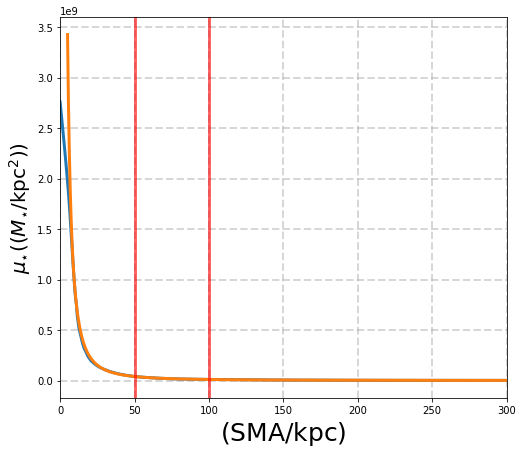

In [163]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.plot((iso['sma_kpc']), 
         (iso['intens_kpc']), linewidth=3.0)

x=np.linspace(5,300, 500)
plt.plot(x, mu_function(x,*p_fit_line), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}((M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(100.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline((50), linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.xlim(0, 300)
plt.xlabel(r'$\mathrm{(SMA/kpc)}}$', fontsize=25)

In [181]:
mass_int, mass_err =quad(mu_r_function, 100, 500, args=tuple(p_fit_line))
mass_int

-1564744740017.003

In [170]:
mass_100 = 10**(oneD_mass(iso, 100))
mass_beyond100 = mass_int
linear_fit_mass = np.log10(mass_100+mass_beyond100)
linear_fit_mass

12.192790099228608

In [114]:
iso['mag_tot'][0]/-2.5

12.241892114354755

# Results 

In [111]:
galSBP_mass = iso['mag_tot'][0]/-2.5 
cat_mass=illustris_masses[0][0]
post_mass=illustris_masses[0][1]

print 'Catalog Mass: %f' %cat_mass
print 'Mass from galSPB measurement: %f' %galSBP_mass
print 'Mass from power law fit to SBP: %f' %power_law_fit_mass
print 'Mass from linear fit to SBP in log: %f' %linear_fit_mass

Catalog Mass: 12.414851
Mass from galSPB measurement: 12.241892


NameError: name 'power_law_fit_mass' is not defined

# Make function to include in get_masses.py

In [15]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

def oneD_mass(galaxy_iso, radius):
    mass=np.interp(radius,galaxy_iso['sma_kpc'], galaxy_iso['growth_ori'])
    return np.log10(mass)

def powerlaw(x, m, c, c0):
    return c0 + x**m * c
def power_law_r(x, m, c, c0):
    return powerlaw(x, m, c, c0)*x
# def powerlaw(x, m, c):
#     return x**m * c
# def power_law_r(x, m, c):
#     return powerlaw(x, m, c)*x

def extrapolated_1D_mass(iso, max_r):
    
    #fit power law between 50 and 100kpc
    x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10])
    
    #print p_fit_power
    
    #integrate between 100 and 500kpc to get mass
    mass_beyond100, mass_err =quad(power_law_r, 100, max_r, args=tuple(p_fit_power))

    #add to galSBP mass to get total mass
    mass_100 = 10**(oneD_mass(iso, 100))
    power_law_fit_mass = np.log10(mass_100+mass_beyond100)
    
    return power_law_fit_mass

In [16]:
extrapolated_1D_mass(iso, np.inf)


TypeError: powerlaw() takes exactly 4 arguments (3 given)

Text(0.5,0,u'$\\mathrm{SMA/kpc}$')

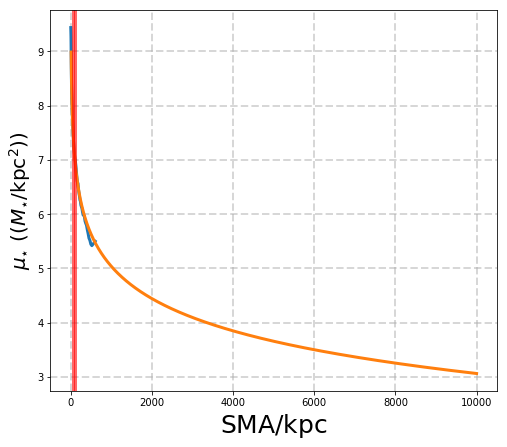

In [86]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.plot((iso['sma_kpc']), np.log10(iso['intens_kpc']), linewidth=3.0)

x=np.linspace(10,10000,100000)
plt.plot(x, np.log10(powerlaw(x,*p_fit_power)), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}\ ((M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(100.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline(50, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
# plt.xlim(50, 1000)
# plt.ylim(0, 1e8)
plt.xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)

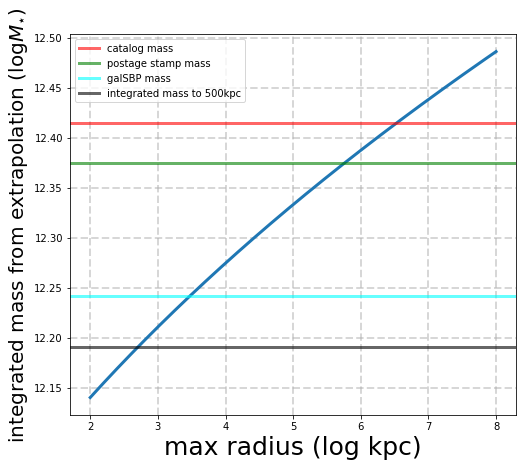

In [112]:
#mass as a function of radius
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

xs=np.logspace(2,8,10000)
masses = [extrapolated_1D_mass(iso, x) for x in xs]
plt.plot(np.log10(xs), masses, linewidth=3.0)

plt.ylabel(r'integrated mass from extrapolation $(\log M_{\star})$', fontsize=20)
plt.axhline(cat_mass, linestyle='-', linewidth=3.0, alpha=0.6, c='r', label='catalog mass')
plt.axhline(post_mass, linestyle='-', linewidth=3.0, alpha=0.6, c='g', label='postage stamp mass')
plt.axhline(galSBP_mass, linestyle='-', linewidth=3.0, alpha=0.6, c='cyan', label='galSBP mass')

plt.axhline(extrapolated_1D_mass(iso, 500), linestyle='-', linewidth=3.0, alpha=0.6, c='k', label='integrated mass to 500kpc')

plt.xlabel(r'max radius (log kpc)', fontsize=25)
plt.legend()

Text(0.5,0,u'max radius (kpc)')

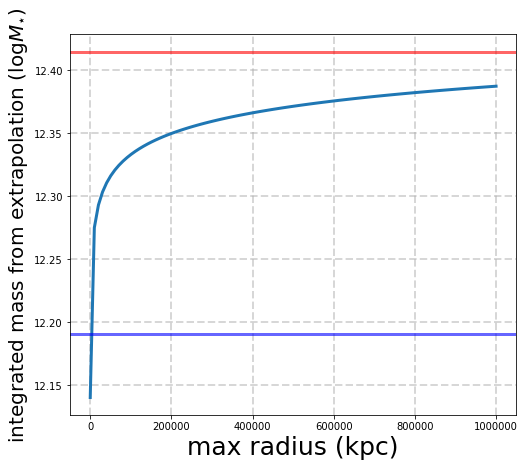

In [97]:
#mass as a function of radius
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

xs=np.linspace(1e2,1e6,100)
masses = [extrapolated_1D_mass(iso, x) for x in xs]
plt.plot(xs, masses, linewidth=3.0)

plt.ylabel(r'integrated mass from extrapolation $(\log M_{\star})$', fontsize=20)
plt.axhline(cat_mass, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axhline(extrapolated_1D_mass(iso, 500), linestyle='-', linewidth=3.0, alpha=0.6, c='b')

plt.xlabel(r'max radius (kpc)', fontsize=25)

In [110]:
quad(power_law_r, 100, 1e16, args=tuple(p_fit_power))

(9321993558428.291, 27990.076171875)

In [10]:
iso=illustris_isos[6]

IndexError: list index out of range

In [5]:
def powerlaw(x, m, c, c0):
    return c0 + x**m * c
def power_law_r(x, m, c, c0):
    return powerlaw(x, m, c, c0)*x
# def powerlaw(x, m, c):
#     return x**m * c
# def power_law_r(x, m, c):
#     return powerlaw(x, m, c)*x


def extrapolated_1D_mass(iso, max_r):

    #fit power law between 50 and 100kpc
    x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10,0])

    #print p_fit_power

    #integrate between 100 and 500kpc to get mass
    mass_beyond100, mass_err =quad(power_law_r, 100, max_r, args=tuple(p_fit_power))

    #add to galSBP mass to get total mass
    mass_100 = 10**(oneD_mass(iso, 100))
    power_law_fit_mass = np.log10(mass_100+mass_beyond100)

    return power_law_fit_mass

In [125]:
iso['sma_kpc']

0.0
2.5476975
2.675082
2.808836
2.949278
3.0967415
3.251578
3.414157
3.5848645
3.764108
3.952313


In [8]:
extrapolated_1D_mass(iso, 500)

12.251786003816793

In [118]:
iso


sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub,sma_kpc,intens_kpc
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,68969150000.0,nan,nan,nan,nan,nan,nan,nan,100.0,nan,101.0,nan,-18941710000.0,nan,nan,0.0,-27.09664,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-23.6017871624,-23.6017871624,-23.6017871624,68969150000.0,0.0,nan,nan,nan,0.0,0.0,0.0,0.0,100.0,101.0,0.79,19.55,15547175.0,68953602825.0,-23.6015423858,0.0,39.9113477631,-30.6047302859,-30.6578320256,-30.6578320256,0.0,2758766000.0
0.5095395,59317600000.0,3941640000.0,20098500000.0,14211780000.0,0.21,0.09372623,19.55,14.75501,100.0,0.02533532,101.0,0.02966275,-19869330000.0,114177800000.0,5.746434,0.8448789,-26.93296,0.07465531,0.06985136,68969150000.0,68969150000.0,-27.09664,-27.09664,1.0,1.0,0.08543383,0.4930948,-0.03586035,0.2108051,-0.109079,0.627485,0.02499579,0.1463199,13,0,1.0,0.0,nan,2.0,-1312832.0,292326656.0,-9675850.0,282669312.0,-2859884.0,292449472.0,-10500768.0,282582560.0,19.55,-23.438108906,-23.438108906,-23.438108906,59317600000.0,0.0,0.0698509972215,-23.5079599033,-23.3682579088,2.5476975,1.26338863329,0.0,0.0,100.0,101.0,0.79,19.55,15547175.0,59302052825.0,-23.4378242967,0.0,39.9113477631,-30.6047302859,-30.6578320256,-30.6578320256,2.5476975,2372704000.0
0.5350164,58812490000.0,4111581000.0,20965030000.0,14824520000.0,0.21,0.095132,19.55,14.97631,100.0,0.02700107,101.0,0.03161303,-19956090000.0,113386100000.0,5.681779,0.8552474,-26.92367,0.07868728,0.0733684,68969150000.0,68969150000.0,-27.09664,-27.09664,1.0,1.0,0.09187277,0.5240318,-0.03222482,0.1884184,-0.1096323,0.623571,0.02551721,0.1476049,13,0,1.0,0.0,nan,2.0,-916701.0,306100544.0,-11642478.0,295988160.0,-2073278.0,306224480.0,-12325037.0,295892800.0,19.55,-23.4288238956,-23.4288238956,-23.4288238956,58812490000.0,0.0,0.073368113731,-23.5021920094,-23.3554557819,2.675082,1.27889318996,3884407641.35,3884407641.35,100.0,101.0,0.79,19.55,15547175.0,58796942825.0,-23.4285368416,3883380792.03,39.9113477631,-30.6047302859,-30.6578320256,-30.6578320256,2.675082,2352499600.0
0.5617672,58279870000.0,4287357000.0,21861320000.0,15458290000.0,0.21,0.09674252,19.55,15.22985,100.0,0.02883109,101.0,0.03375563,-20051010000.0,112558600000.0,5.613615,0.8657432,-26.9138,0.08296169,0.07707173,68969150000.0,68969150000.0,-27.09664,-27.09664,1.0,1.0,0.09857172,0.5552635,-0.02843071,0.1656907,-0.1101783,0.6191583,0.02605146,0.1488053,13,0,1.0,0.0,nan,2.0,-452092.4,320595456.0,-13853417.0,310004192.0,-1151187.0,320719072.0,-14366816.0,309898368.0,19.55,-23.4189464142,-23.4189464142,-23.4189464142,58279870000.0,0.0,0.0770708324386,-23.4960172466,-23.3418755818,2.808836,1.29458805547,8128191539.44,8128191539.44,100.0,101.0,0.79,19.55,15547175.0,58264322825.0,-23.4186567364,8126032586.51,39.9113477631,-30.6047302859,-30.6578320256,-30.6578320256,2.808836,2331194800.0
0.5898556,57717870000.0,4469015000.0,22787590000.0,16113260000.0,0.21,0.09860943,19.55,15.5